In [1]:
import numpy as np

In [2]:
import os.path as op

import nibabel as nib
import pandas as pd

from AFQ import api
import AFQ.data as afd

/Users/arokem/.virtualenvs/life-support/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
afd.organize_stanford_data()

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/stanford_hardi 


In [4]:
base_dir = op.join(op.expanduser('~'), 'AFQ_data', 'stanford_hardi')

In [5]:
myafq = api.AFQ(bids_path=op.join(afd.afq_home,
                                  'stanford_hardi'),
                dmriprep='vistasoft',
                tracking_params=dict(n_seeds=2),
                segmentation_params = dict(return_idx = True))

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/AFQ_data/callosum_templates 
/Users/arokem/.virtualenvs/life-support/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


In [6]:
import matplotlib.pyplot as plt

In [7]:
myafq.export_bundles()

INFO:AFQ.api:Saving /Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/clean_bundles/sub-01_ses-01_dwi_space-RASMM_model-DTI_desc-det-AFQ-ATR_R_tractography.trk
INFO:AFQ.api:Saving /Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/clean_bundles/sub-01_ses-01_dwi_space-RASMM_model-DTI_desc-det-AFQ-ATR_L_tractography.trk
INFO:AFQ.api:Saving /Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/clean_bundles/sub-01_ses-01_dwi_space-RASMM_model-DTI_desc-det-AFQ-CGC_R_tractography.trk
INFO:AFQ.api:Saving /Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/clean_bundles/sub-01_ses-01_dwi_space-RASMM_model-DTI_desc-det-AFQ-CGC_L_tractography.trk
INFO:AFQ.api:Saving /Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/clean_bundles/sub-01_ses-01_dwi_space-RASMM_model-DTI_desc-det-AFQ-CST_R_tractography.trk
INFO:AFQ.api:Saving /Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/clean_bundles/sub-01_s

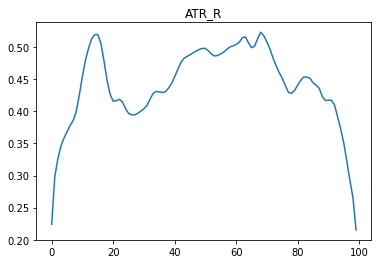

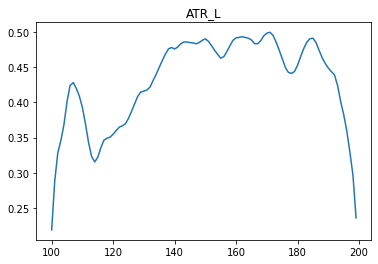

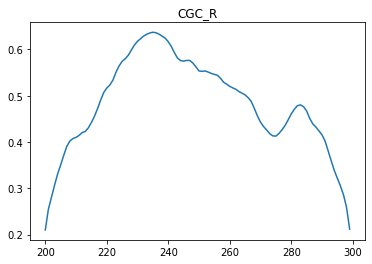

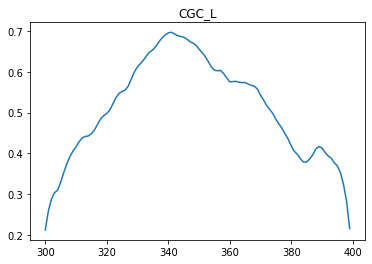

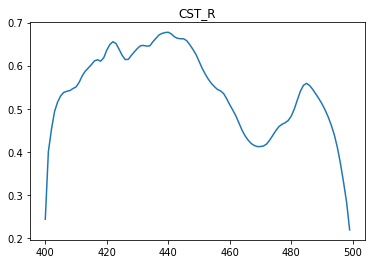

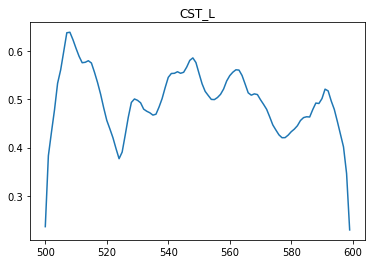

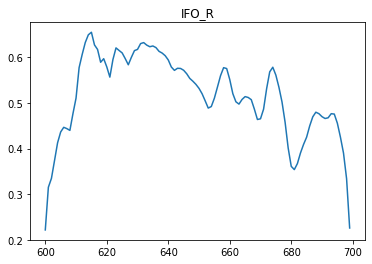

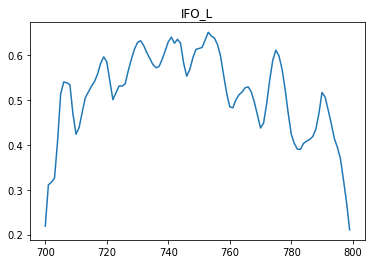

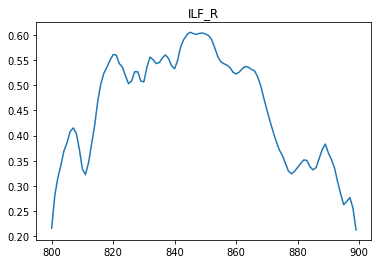

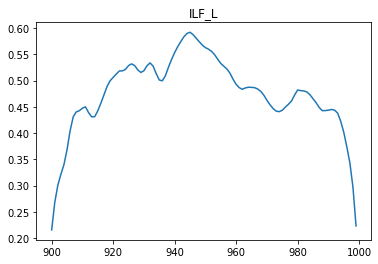

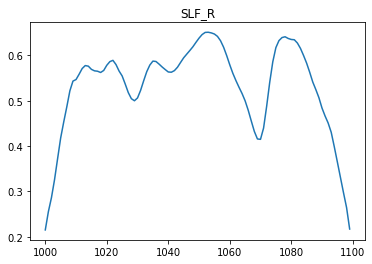

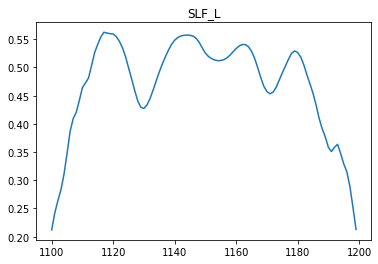

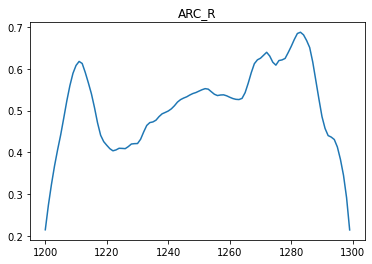

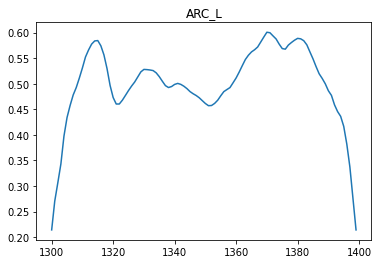

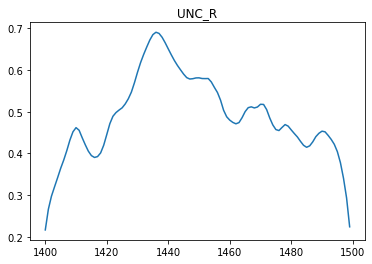

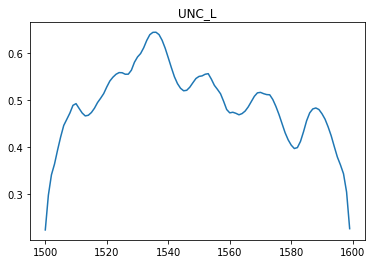

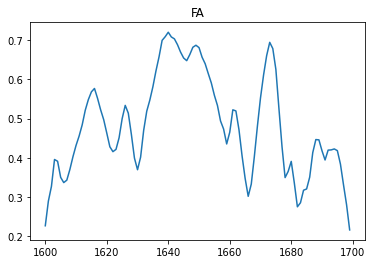

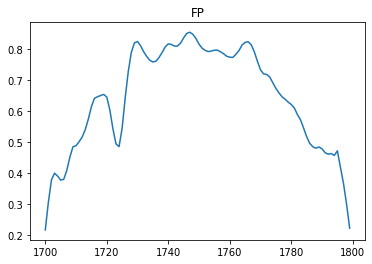

In [8]:
df = pd.read_csv(myafq.tract_profiles[0])
for bundle in df['bundle'].unique():
    fig, ax = plt.subplots(1)
    ax.plot(df[(df['bundle'] == bundle)]['dti_fa'])
    ax.set_title(bundle)

In [9]:
import dipy.tracking.life as life


In [10]:
gtab = myafq.gtab[0]

In [11]:
gtab

In [12]:
data = myafq.dwi_img[0].get_fdata()

In [13]:
fiber_model = life.FiberModel(gtab)

In [14]:
from dipy.io.streamline import load_trk

In [15]:
sft = load_trk(
    "/Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/sub-01_ses-01_dwi_space-RASMM_model-DTI_desc-det-AFQ-clean_tractography.trk",
    "same")

In [16]:
sft.to_vox()

In [17]:
fiber_fit = fiber_model.fit(data, sft.streamlines, np.eye(4))

/Users/arokem/source/dipy/dipy/tracking/life.py:431: RuntimeWarning: divide by zero encountered in true_divide
  relative_signal = (weighted_signal/b0_signal[:, None])
/Users/arokem/source/dipy/dipy/tracking/life.py:435: RuntimeWarning: invalid value encountered in subtract
  to_fit = (relative_signal - mean_sig[:, None]).ravel()


In [18]:
bundle = "ARC_L"

In [19]:
uid = myafq.bundle_dict[bundle]['uid']

In [20]:
uid

14

In [21]:
bundle_idx = sft.data_per_streamline['bundle'] == uid

In [22]:
bundle_matrix = fiber_fit.life_matrix[:]

In [23]:
bundle_matrix[:, ~bundle_idx] = 0

IndexError: invalid index shape

In [ ]:
fiber_fit.life_matrix.nnz

In [ ]:
bundle_matrix.nnz

In [ ]:
pred_weighted = np.reshape(spdot(bundle_matrix, 
                                 fiber_fit.beta),
                           (fiber_fit.vox_coords.shape[0],
                            np.sum(~gtab.b0s_mask)))

In [ ]:
pred = np.empty((fiber_fit.vox_coords.shape[0], gtab.bvals.shape[0]))
S0 = fiber_fit.b0_signal
pred[..., gtab.b0s_mask] = S0[:, None]
pred[..., ~gtab.b0s_mask] =\
    (pred_weighted + fiber_fit.mean_signal[:, None]) * S0[:, None]

In [ ]:
vol_pred = np.zeros(data.shape)
vol_pred[fiber_fit.vox_coords[:, 0],
         fiber_fit.vox_coords[:, 1],
         fiber_fit.vox_coords[:, 2]] = pred
vol_pred[np.isnan(vol_pred)] = 0

mask = np.zeros(data.shape[:3])
mask[fiber_fit.vox_coords[:, 0],
     fiber_fit.vox_coords[:, 1],
     fiber_fit.vox_coords[:, 2]] = 1

In [ ]:
from dipy.reconst import dti

In [ ]:
np.any(np.isnan(pred))

In [ ]:
np.any(np.isnan(vol_pred))

In [ ]:
dt_model = dti.TensorModel(gtab)

In [ ]:
dt_fit = dt_model.fit(vol_pred, mask=mask)

In [ ]:
plt.matshow(dt_fit.fa[43])

In [ ]:
from dipy.stats.analysis import afq_profile


In [ ]:
bundle_sft = load_trk(
    "/Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/clean_bundles/sub-01_ses-01_dwi_space-RASMM_model-DTI_desc-det-AFQ-FP_tractography.trk",
    "same")

In [ ]:
bundle_sft.to_vox()

In [ ]:
profile = afq_profile(dt_fit.fa, bundle_sft.streamlines, np.eye(4))

In [ ]:
plt.plot(np.arange(100), profile)
plt.plot(np.arange(100), df[(df['bundle'] == "FP")]['dti_fa'])